## Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.mstats import normaltest
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz, plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
import time
from sklearn import tree
from imblearn.over_sampling import RandomOverSampler, SMOTE
import lime.lime_tabular
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")
rs=12

## Importing the Dataset

In [2]:
# reading the data
df=pd.read_csv('dataset.csv')

In [3]:
# Visualizing the table
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


# 1. Description of the Data

The Data is taken from Kaggle.com. Prediction of Cerebral stroke is a very important study becasue it can save life of people who are at risk of cerebral stroke by looking into different attributes like somking_status,hypertension.
Below the name of attributes along with the datatype is shown.

In [4]:
# Information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


id is a unique number number given to different cases.

Let's look into classes and distribution of all Categorical Variables.

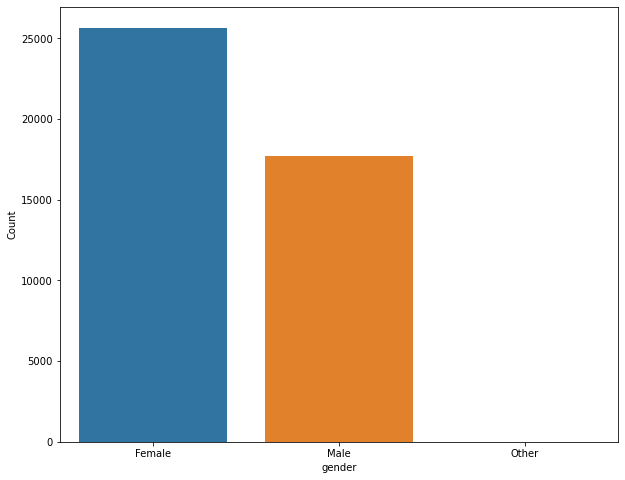

<Figure size 432x288 with 0 Axes>

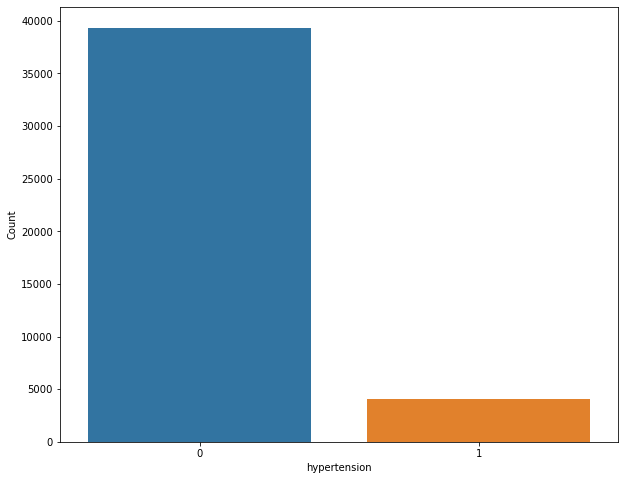

<Figure size 432x288 with 0 Axes>

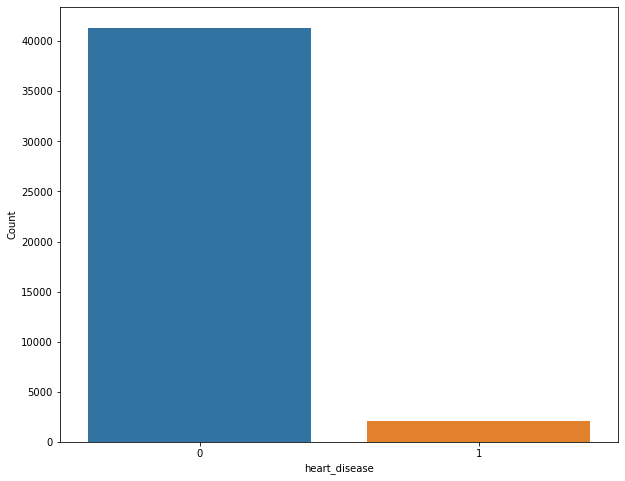

<Figure size 432x288 with 0 Axes>

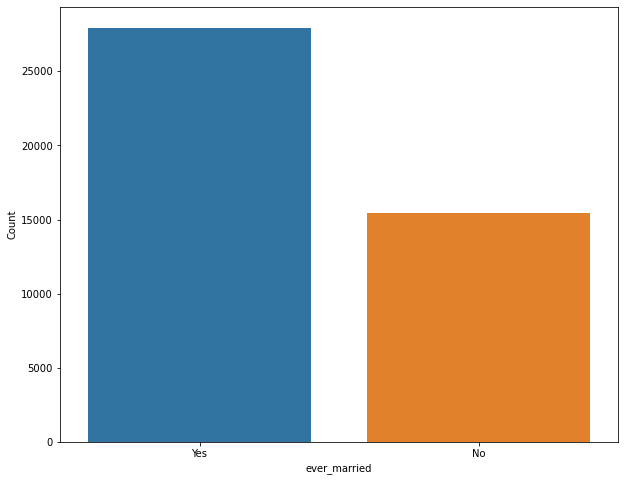

<Figure size 432x288 with 0 Axes>

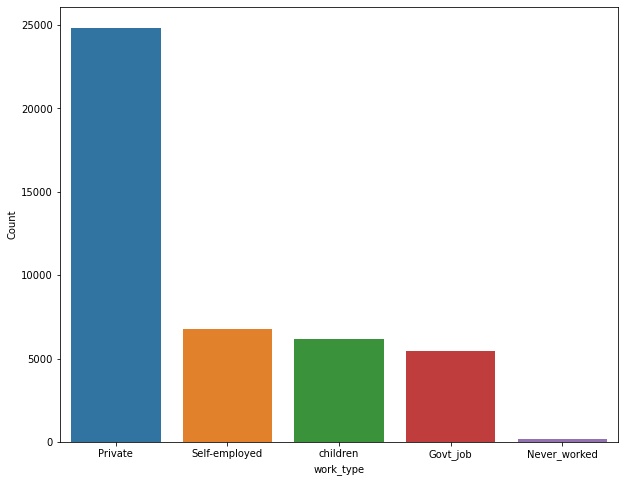

<Figure size 432x288 with 0 Axes>

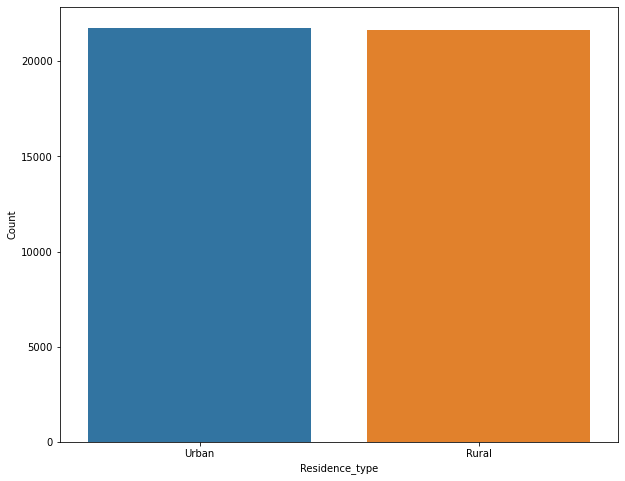

<Figure size 432x288 with 0 Axes>

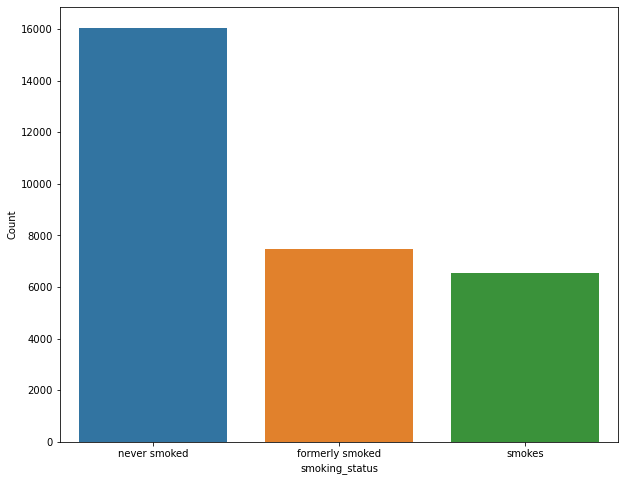

<Figure size 432x288 with 0 Axes>

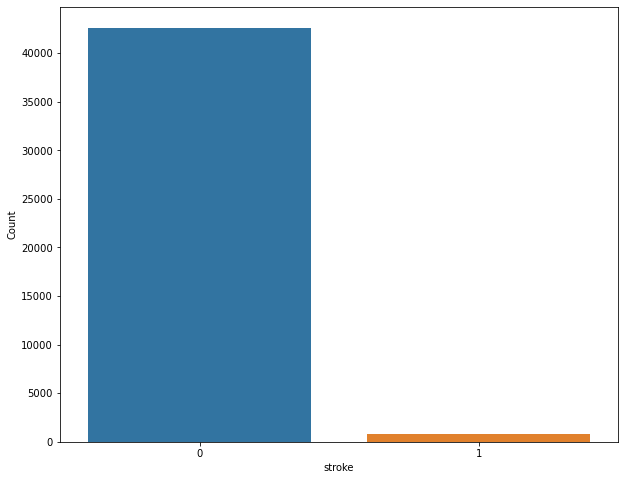

<Figure size 432x288 with 0 Axes>

In [5]:
# distribution of categorical variables
mask_categorical = df.dtypes != np.float
category_cols = df.columns[mask_categorical]
category_cols=category_cols.tolist()
category_cols.remove('id')
for col in category_cols:
    fig, ax = plt.subplots(figsize = (10,8))
    plt1 = sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt1.set(xlabel = col, ylabel= 'Count')
    plt.show()
    plt.tight_layout()

From the above plots we can see the all the categorical variable along with classes and distirbution of that categorical variable.

Gender have 3 classes Male,Female,Others.

Hypertension have 2 classes 0 and 1. 0 means no and 1 means yes.

heart_disease have 2 classes 0 and 1. 0 means no and 1 means yes.

ever_married have two classes Yes and No.

work_type have s 5 classes chidren, Private,Never-worked,Self_employed,Govt_job.

Residence_type have 2 classes Rural and Urban.

Smoking Status have 3 classes never smoked, formaly smoked, smokes.

Stroke have 2 classes 0 an 1 where 0 means not having a stroke and 1 means yes having a stroke.It is our target variable as welL and we can see that this is an imablanced dataset. So.we need to take nessecary step to accurately model the problem.

Let's look in to the distribution of continuous variable.

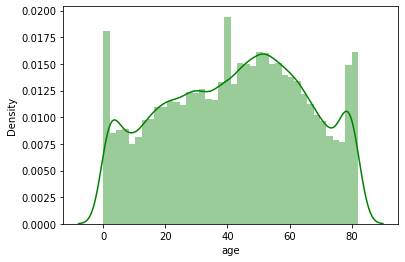

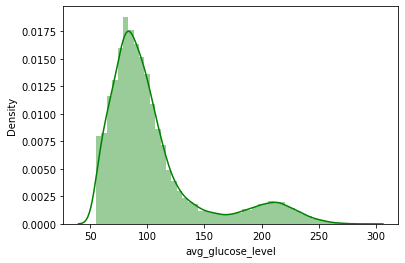

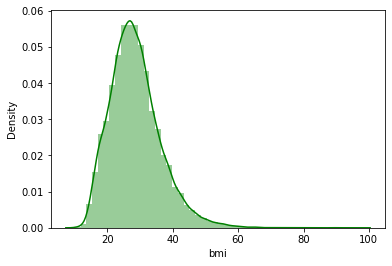

In [6]:
# distribution of continuous variables
mask_numeric = df.dtypes == np.float
numeric_cols = df.columns[mask_numeric]
numeric_cols=numeric_cols.tolist()
for col in numeric_cols:
    sns.distplot(df[col],color='green',hist=True)
    plt.show()

From the above plot we can see that 'avg_glucose_level' and 'bmi' have right skewed distribution. We might like to fix it the later stage.

# 2. Objectives

Our goal will be to accurately predict the likelihood of a patient experiencing a cerebral stroke. Additionally, we will aim to identify the key contributing factors that can initiate a cerebral stroke. This information will help doctors evaluate the risk of cerebral stroke in their patients and take necessary preventive measures.

1. At first, we will do data cleaning in form of finding and handling null values in rows.
2. Looking into the distribution of the continuous attributes and if they are not normally distributed then dealing with it.
3. Doing some Statistical analysis on the data do get some inference.
4. Convertical categorical variable of object data type to int type.
5. Scaling the continuous variable using StandardScaler
6. Fitting simple classification models to the data using Class Reweighting.
7. Fitting progressive complex models to get good accuracy and getting model explanation of the complex models.

# 3.Data cleaning and Feature Engineering

The first step of this process is to find out the duplicates and removing them from the dataset. From this operation ID attribute is used to find out the duplicates.

In [7]:
# Check for duplicate data
duplicate = df[df.duplicated(['id'])]
duplicate

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


As we can see that there is no duplicate rows in the dataset.

Now.Lets check whether there is any columns with null value.

In [8]:
df.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

From the above table it can be seen that there is null values in 'bmi' and 'smoking_status'.

We will remove the rows where 'smoking_status' is not known as this variable has lots of null values. So, if we try to replace the null value by some class then it can change the distribution drastically and from the below plot we can see that most of those rows where 'smoking_status' is not known belongs to class 0 of 'stroke' attributes so this rows will not have much impact on our goal as our goal is too correctly predict class 1 of 'stroke'.

In [9]:
smoke_null = df[df['smoking_status'].isnull()]

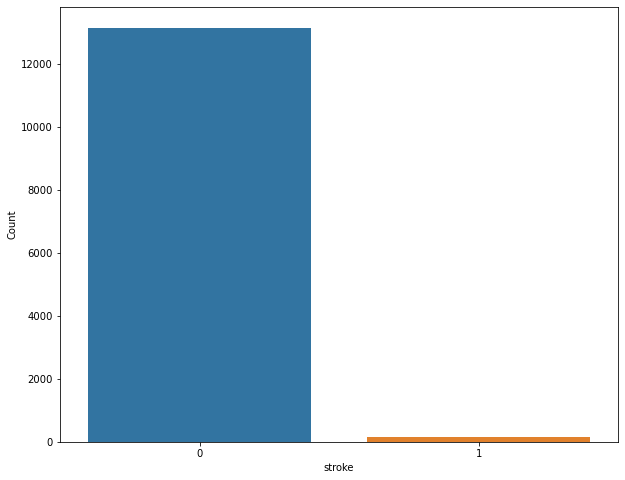

<Figure size 432x288 with 0 Axes>

In [10]:
fig, ax = plt.subplots(figsize = (10,8))
plt1 = sns.countplot(data=smoke_null, x='stroke', order=smoke_null['stroke'].value_counts().index)
plt1.set(xlabel = 'stroke', ylabel= 'Count')
plt.show()
plt.tight_layout()

In [11]:
# Removing rows where 'smoking_status' is null
df = df[df['smoking_status'].notnull()]

We need to deal with the null value of the 'bmi'. But before that let's make a copy of the current dataframe.

Let's make a copy of the dataframe.

In [12]:
X=df.copy()
X.drop('id',axis=1,inplace=True)

We have already noticed the skewness of the variable 'bmi' and 'avg_glucose_level'. We need to fix this or it can cause problem for some of our ML models. 

Let's do normaltest on 'bmi'. 

In [13]:
normaltest(X.bmi.dropna().values)

NormaltestResult(statistic=5332.784217775925, pvalue=0.0)

The above result confirm our assumption of  distribution of 'bmi' not being normal.

We will try to fix the skew of the 'bmi' variable in the next step by transforming the distribution of the variable.

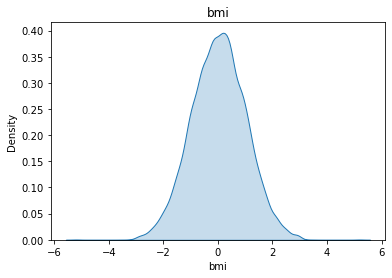

In [14]:
from sklearn.preprocessing import QuantileTransformer
qt_bmi = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=0)
X['bmi']=qt_bmi.fit_transform(np.array(X['bmi']).reshape(-1, 1))
sns.kdeplot(X['bmi'], shade=True)
plt.title('bmi')
plt.show() 

Let's do normaltest on the transformed 'bmi'.

In [15]:
normaltest(X.bmi.dropna().values)

NormaltestResult(statistic=1.2207292355120887, pvalue=0.5431527898136755)

From the statistic above and also from the plot we can say that we have sucessfully fixed the skew of the 'bmi'.

Let's do normal test on 'avg_glucose_level'.

In [16]:
normaltest(X.avg_glucose_level.dropna().values)

NormaltestResult(statistic=7407.283741310126, pvalue=0.0)

The Statistics above suggests that 'avg_glucose_level' is not normally distributed whcih can be seen from the previous plotted distribution of 'avg_glucose_level'.

In the next step we will try to fix the skew of 'avg_glucose_level' by transforming the distribution of the variable.

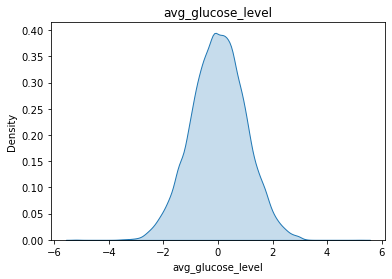

In [17]:
qt_avg_glucose_level = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=0)
X['avg_glucose_level']=qt_bmi.fit_transform(np.array(X['avg_glucose_level']).reshape(-1, 1))
sns.kdeplot(X['avg_glucose_level'], shade=True)
plt.title('avg_glucose_level')
plt.show() 

Let's do normal test on the transformed 'avg_glucose_level'.

In [18]:
normaltest(X.avg_glucose_level.dropna().values)

NormaltestResult(statistic=2.9620890572953744, pvalue=0.2274000384346997)

From the statistics above we can say that now the 'avg_glucose_level' is normally distributed.

Let's do normaltest on the variable 'age'.

In [19]:
normaltest(X.age.values)

NormaltestResult(statistic=5992.178508157799, pvalue=0.0)

We can see that the 'age' variable is not normal. But in this case we are not going to apply transformation to 'age'. Rather we will look into the skew of the data and if the skew is low then we will leave the distribution as it is.

In [20]:
X.age.skew()

-0.020502287801332016

We can see that the skew is low. So, we will leave the distribution as it is.

Now we will try to find out the relation of different variable with stroke.

We will start with continuous variables.

In the next step we will plot the distribution of continous variables for every class of 'stroke' which is 0 and 1.

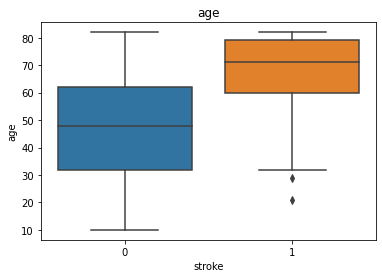

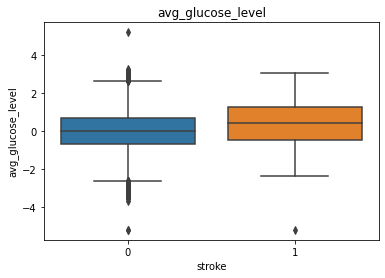

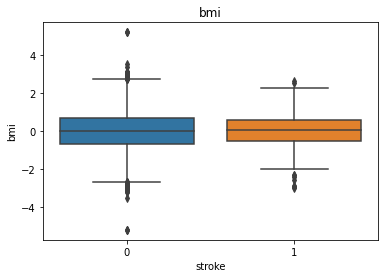

In [21]:
for col in numeric_cols:
    sns.boxplot(x='stroke', y=col, data=X)
    plt.title(col)
    plt.show()

From the above distribution we can say for sure that 'age' and 'avg_glucose_level' has strong relation with 'stroke'.

Let's do one statistical test to prove one of our claim.

Let's propose a hypothesis.

Null hypothesis: Person having Cerebral Stroke doesn't depend on the avg_glucose_level of the person.

Alternate Hypothesis: Person having Cerebral Stroke does depend on the avg_glucose_level of the person.

We set the significance level for p-value to be 0.05.

Let's do another visual inspection first.

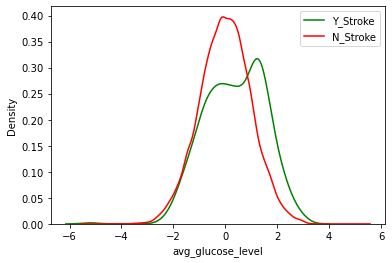

In [22]:
Y_Stroke=X.loc[X.stroke==1]
N_Stroke=X.loc[X.stroke==0]
Y_Stroke_avg_glucose_level = Y_Stroke.avg_glucose_level
N_Stroke_avg_glucose_level = N_Stroke.avg_glucose_level
sns.distplot(Y_Stroke_avg_glucose_level,color='green',hist=False)
sns.distplot(N_Stroke_avg_glucose_level,color='red',hist=False)
plt.legend(['Y_Stroke', 'N_Stroke'])

We can clearly see that the distribution of 'avg_glucose_level' for different class of stroke [0:N_Stroke,1:Y_Stroke] is very different. Let's do a statistical test(F-test) to quantitatively prove our hypothesis.

In [23]:
f, p = stats.f_oneway(Y_Stroke_avg_glucose_level, N_Stroke_avg_glucose_level)
print("F-statistic:", f)
print("p-value:", p)

F-statistic: 90.14513457870854
p-value: 2.3708509554921118e-21


We can see that p-value is very low compared to 0.05. So, we reject the Null Hypothesis and can say that 'avg_glucose_level' does have effect on 'stroke'.

Now we will look into the distribution of categorical variables for stroke class 1. From this we will try to get idea of effect of different class of categorical variable on Stroke. 

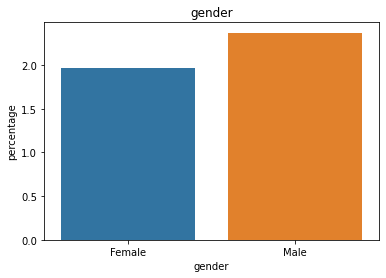

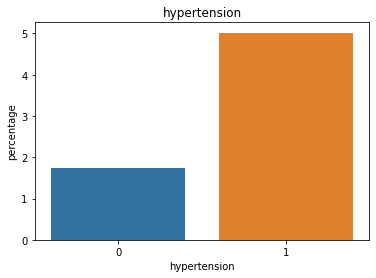

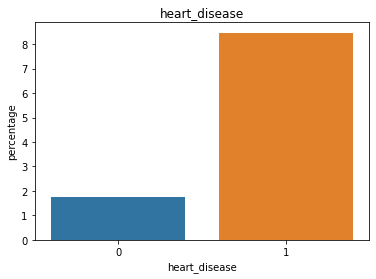

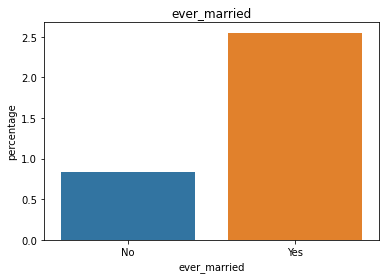

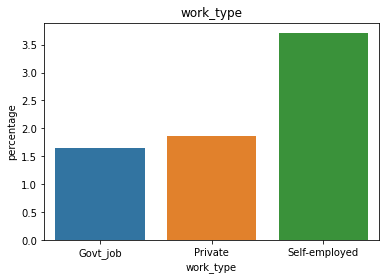

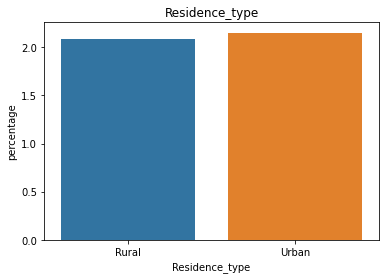

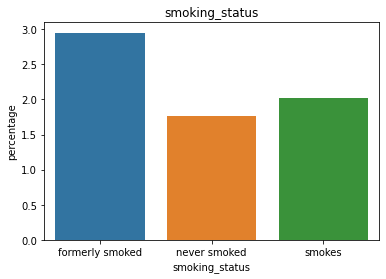

In [24]:
for col in category_cols:
        if col!='stroke':
            # calculate the percentage of occurrences
            percentage = X.groupby(['stroke',col]).size().div(X.groupby([col]).size(), level=col)*100
            percentage = percentage.reset_index(name='percentage')

            # Create a stacked bar chart
            # plt.figure(figsize=(10, 8))
            Y_Stroke=percentage.loc[percentage.stroke==1]
            sns.barplot(x=col, y='percentage', data=Y_Stroke, dodge=True)
            plt.title(col)
            plt.show()

The plots above shows that what percentage of certain class having stroke. For example Let's Consider all the heart_disease class 1 people as 100%. Out of that 100%, more that 8% of the people have'stroke' class 1.

From the above plot we can say that 'hypertension' and 'heart_disease' categorical variable does have a role to play in 'stroke'. Some variable like  'ever_married','work_type' and 'somking_status' also looking to have effect on 'stroke'.

Let's do a statistical test to check wheather 'smoking_status' have relation with 'stroke'.

Let's propose a hypothesis.

Null hypothesis: Person having Cerebral Stroke doesn't depend on the smoking_status of the person.

Alternate Hypothesis: Person having Cerebral Stroke does depend on the smoking_status of the person.

We set the significance level for p-value to be 0.05.

We need to perform ch_square test between 'stroke' and 'smoking_status' column.

In [25]:
ct = pd.crosstab(X['smoking_status'], X['stroke'])
chi2, p, dof, expected = chi2_contingency(ct)
print(f'chi2: {chi2}, p-value: {p}')

chi2: 34.654573576807856, p-value: 2.9843857761841864e-08


As the p-value is much less than 0.05. So,we can reject the null hypothesis and can say that 'smoking_status' does have relation with 'stroke'.

Let's split our data set into train set and test set. We need stratified split so that ratio of class twos classes of 'stroke' remain same in train set and test set.

In [26]:
new_column_names = {old_name: old_name.replace('_', '-') for old_name in X.columns}
X = X.rename(columns=new_column_names)

In [27]:
y=X.pop('stroke')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 12)

Let's check wheather after split the ratio of classes in 'stroke' is same or not. 

In [29]:
train_set_distribution = dict(zip(*np.unique(y_train, return_counts=True)))
test_set_distribution = dict(zip(*np.unique(y_test, return_counts=True)))

In [30]:
print("Training set distribution: ", {k: v/len(y_train) for k, v in train_set_distribution.items()})
print("Test set distribution: ", {k: v/len(y_test) for k, v in test_set_distribution.items()})

Training set distribution:  {0: 0.9788258739516732, 1: 0.02117412604832683}
Test set distribution:  {0: 0.9787446031218864, 1: 0.021255396878113585}


We can see that ratio of the classes in 'stroke' column of train set and test set  is same.

Let's fill the null value of 'bmi' in X_train and X_test using median of the variable.

In [31]:
from sklearn.impute import SimpleImputer
imputer_bmi = SimpleImputer(strategy='median')
imputer_bmi.fit(X_train[['bmi']])
X_train[['bmi']] = imputer_bmi.transform(X_train[['bmi']])
X_test[['bmi']] = imputer_bmi.transform(X_test[['bmi']])

Let's check the number of null values in train set and test set now.

In [32]:
X_train.isnull().sum()

gender               0
age                  0
hypertension         0
heart-disease        0
ever-married         0
work-type            0
Residence-type       0
avg-glucose-level    0
bmi                  0
smoking-status       0
dtype: int64

In [33]:
X_test.isnull().sum()

gender               0
age                  0
hypertension         0
heart-disease        0
ever-married         0
work-type            0
Residence-type       0
avg-glucose-level    0
bmi                  0
smoking-status       0
dtype: int64

Now there is no null values in any column of test set and train set.

We need to scale our continuous variable so no variable gets more weightage during ML model fitting.

In [34]:
ss=StandardScaler()
mask_numeric = X_train.dtypes == np.float
numeric_cols = X_train.columns[mask_numeric]
numeric_cols=numeric_cols.tolist()
X_train[numeric_cols]=ss.fit_transform(X_train[numeric_cols])
X_test[numeric_cols]=ss.transform(X_test[numeric_cols])

In [35]:
X_train.head(10)

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status
34311,Female,-1.436515,0,0,No,Private,Urban,0.225746,-0.576088,smokes
3599,Female,-1.596630,0,0,No,Private,Urban,0.138424,-1.091727,never smoked
20698,Female,1.498923,0,0,No,Self-employed,Urban,-0.212688,-1.127989,never smoked
37233,Male,0.698349,0,0,Yes,Govt_job,Rural,0.390686,1.892855,never smoked
5516,Male,-1.810117,0,0,No,children,Rural,-1.127060,1.294373,never smoked
27875,Male,0.484863,0,0,Yes,Self-employed,Rural,-0.413891,0.177561,formerly smoked
12425,Female,-1.062914,0,0,Yes,Private,Urban,-0.510339,0.017832,never smoked
13839,Female,-1.223029,0,0,No,Private,Rural,-0.186656,-0.182252,formerly smoked
39451,Female,-0.315711,0,0,Yes,Private,Rural,-1.361022,-0.117813,smokes
37092,Female,1.605667,0,0,Yes,Private,Urban,0.321633,-0.609021,formerly smoked


In [36]:
X_test.head(10)

,gender,age,hypertension,heart-disease,ever-married,work-type,Residence-type,avg-glucose-level,bmi,smoking-status
10746,Female,-1.383144,0,0,Yes,Private,Urban,0.620387,0.667580,smokes
33021,Female,0.965207,0,0,Yes,Private,Rural,-0.683266,0.445146,formerly smoked
36741,Male,0.911836,0,0,Yes,Self-employed,Urban,0.441359,-1.127989,never smoked
43371,Female,1.605667,0,0,Yes,Private,Urban,1.164620,-0.000071,formerly smoked
41844,Male,0.805092,0,0,Yes,Self-employed,Rural,-1.469517,1.194767,formerly smoked
9991,Male,0.698349,0,0,Yes,Govt_job,Rural,-1.582151,0.120527,formerly smoked
41221,Female,-0.369083,0,0,Yes,Self-employed,Rural,0.198567,0.852956,smokes
22078,Female,0.057890,0,0,Yes,Govt_job,Rural,-0.000925,1.050681,never smoked
10448,Male,-0.902799,0,0,No,Govt_job,Rural,-0.882937,0.743419,smokes
21696,Female,0.324748,1,0,Yes,Govt_job,Rural,-0.330133,0.795240,smokes


We need to deal with categorical columns of object datatype. We will use onehotencoder to convert this catgorical variable of object dataype to integer datatype so we can fit ML models.

In [37]:
mask_categorical_object = X_train.dtypes == np.object
category_cols_object_dtype = X_train.columns[mask_categorical_object]
category_cols_object_dtype =category_cols_object_dtype.tolist()
one_hot = ColumnTransformer(transformers=[("one_hot", OneHotEncoder(), category_cols_object_dtype) ],remainder="passthrough")
X_train=one_hot.fit_transform(X_train)
X_test=one_hot.transform(X_test)

In [38]:
names=one_hot.get_feature_names_out()
# colunm_names=[name[name.find("_")+1:] for name in  [name[name.find("__")+2:] for name in names]]
colunm_names=[name[name.find("__")+2:] for name in names]

In [39]:
X_train=pd.DataFrame(data=X_train,columns=colunm_names)
X_train.head(10)

,gender_Female,gender_Male,gender_Other,ever-married_No,ever-married_Yes,work-type_Govt_job,work-type_Never_worked,work-type_Private,work-type_Self-employed,work-type_children,Residence-type_Rural,Residence-type_Urban,smoking-status_formerly smoked,smoking-status_never smoked,smoking-status_smokes,age,hypertension,heart-disease,avg-glucose-level,bmi
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.436515,0.0,0.0,0.225746,-0.576088
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.596630,0.0,0.0,0.138424,-1.091727
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.498923,0.0,0.0,-0.212688,-1.127989
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.698349,0.0,0.0,0.390686,1.892855
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,-1.810117,0.0,0.0,-1.127060,1.294373
5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.484863,0.0,0.0,-0.413891,0.177561
6,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.062914,0.0,0.0,-0.510339,0.017832
7,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.223029,0.0,0.0,-0.186656,-0.182252
8,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.315711,0.0,0.0,-1.361022,-0.117813
9,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.605667,0.0,0.0,0.321633,-0.609021


In [40]:
X_test=pd.DataFrame(data=X_test,columns=colunm_names)
X_test.head(10)

,gender_Female,gender_Male,gender_Other,ever-married_No,ever-married_Yes,work-type_Govt_job,work-type_Never_worked,work-type_Private,work-type_Self-employed,work-type_children,Residence-type_Rural,Residence-type_Urban,smoking-status_formerly smoked,smoking-status_never smoked,smoking-status_smokes,age,hypertension,heart-disease,avg-glucose-level,bmi
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.383144,0.0,0.0,0.620387,0.667580
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.965207,0.0,0.0,-0.683266,0.445146
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.911836,0.0,0.0,0.441359,-1.127989
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.605667,0.0,0.0,1.164620,-0.000071
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.805092,0.0,0.0,-1.469517,1.194767
5,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.698349,0.0,0.0,-1.582151,0.120527
6,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.369083,0.0,0.0,0.198567,0.852956
7,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.057890,0.0,0.0,-0.000925,1.050681
8,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.902799,0.0,0.0,-0.882937,0.743419
9,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.324748,1.0,0.0,-0.330133,0.795240


In [41]:
for col in X_train.columns:
    if set(X_train[col].unique()) == {0, 1}:
        X_train[col] = X_train[col].astype(int)

In [42]:
for col in X_test.columns:
    if set(X_test[col].unique()) == {0, 1}:
        X_test[col] = X_test[col].astype(int)

# 4. Classification  Models

Our main objective will be to get a explaination of 'stroke'. Because of which we can't use Dimensionality Reduction algorithm on our dataset. After getting some explaination for 'stroke', we might focus on more accurate prediction.

Classes in our target variable is imbalanced. In other word, our target variable is skewed. To deal with this, we can use SMOTE, Class Reweighting or undersmaling method. Out of which undersmaoling will not be a good choice because high skewness of the target variable 'stroke' shown below. We will go with Class Reweighting first.

For this dataset as predicting 'stroke' correctly has much impact than incorrectly predicting 'stroke', so we will focus on 'Recall' and 'ROC-AUC' value  of model on test set.

### a) Logistic Regression with Class Reweighting

Let's first build simple logistic regression model without class reweighting and predict with it.

In [43]:
lr_model = LogisticRegression(random_state=rs,max_iter=1000)

lr_model.fit(X_train, y_train)
y_preds_lr = lr_model.predict(X_test)

Function in the below cell will give us Accuracy,Precision,Recall,Fscore and ROC-AUC given predicted data and actual data.

In [44]:
def evaluate_metrics(yt, yp):
    accuracy = accuracy_score(yt, yp)
    precision, recall, fbeta, support = precision_recall_fscore_support(yt, yp, beta=2, pos_label=1, average='binary')
    auc = roc_auc_score(yt, yp)
    print(f"Accuracy is: {accuracy:.2f}")
    print(f"Precision is: {precision:.2f}")
    print(f"Recall is: {recall:.2f}")
    print(f"Fscore is: {fbeta:.2f}")
    print(f"AUC is: {auc:.2f}")

As we can see below this 'lr_model' didn't perform well in terms of AUC and Recall.

In [45]:
evaluate_metrics(y_test,y_preds_lr)

Accuracy is: 0.98
Precision is: 0.00
Recall is: 0.00
Fscore is: 0.00
AUC is: 0.50


Let's build a logistic regression with class_weight parameter which will do the class reweighting for us on the 'target variable'.

In [46]:
class_weight={0:0.05,1:0.95}

In [47]:
lr_model_class_weight = LogisticRegression(random_state=rs, 
                              max_iter = 1000,
                              class_weight=class_weight)

In [48]:
lr_model_class_weight.fit(X_train, y_train)
y_preds_lr_class_weight = lr_model_class_weight.predict(X_test)

From the below result we can see that our logistic regression model imporved with class reweighting.

In [49]:
evaluate_metrics(y_test, y_preds_lr_class_weight)

Accuracy is: 0.86
Precision is: 0.08
Recall is: 0.51
Fscore is: 0.24
AUC is: 0.69


Let's try to tune hyper-parameters of Logistic Regression.(Below cell can be uncommented to get the tuned hyper-parameters)

In [50]:
# param_grid_lr = {
#     'penalty': ['l1', 'l2'],
#     'C': [0.001, 0.01, 0.1, 1,10],
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9},'balanced'],
# }

In [51]:
# cv = StratifiedKFold(n_splits=5) 
# lr_grid_search = GridSearchCV(estimator=lr_model,param_grid=param_grid_lr, 
#                               scoring='roc_auc',cv=cv,n_jobs=8)
# lr_grid_search.fit(X_train, y_train)

In [52]:
# lr_grid_search_best=lr_grid_search.best_estimator_
# print(lr_grid_search_best.get_params())

In [53]:
# y_preds_lr_grid_search_best=lr_grid_search_best.predict(X_test)

In [54]:
# evaluate_metrics(y_test, y_preds_lr_grid_search_best)

Below is the Logistic Regression model with tuned hyper-parameter.

In [55]:
lr_class_weight_hp_tuned=LogisticRegression(C= 10, 
    class_weight= {0: 0.05, 1: 0.95}, dual= False, 
    fit_intercept= True, intercept_scaling= 1, 
    l1_ratio=None, max_iter=1000, 
    multi_class= 'auto',n_jobs=8, 
    penalty= 'l2', random_state= rs, solver= 'lbfgs', tol = 0.0001,verbose=  0, warm_start= False)

In [56]:
lr_class_weight_hp_tuned.fit(X_train, y_train)

LogisticRegression(C=10, class_weight={0: 0.05, 1: 0.95}, max_iter=1000,
                   n_jobs=8, random_state=12)

In [57]:
y_preds_lr_class_weight_hp_tuned=lr_class_weight_hp_tuned.predict(X_test)

From the below table we can see that  results didn't improved much.

In [58]:
evaluate_metrics(y_test, y_preds_lr_class_weight_hp_tuned)

Accuracy is: 0.86
Precision is: 0.08
Recall is: 0.52
Fscore is: 0.24
AUC is: 0.69


Let's try to look into the co-efficients of the tuned Logistic Regression model to get some idea that which attributes have major relation with 'stroke'.

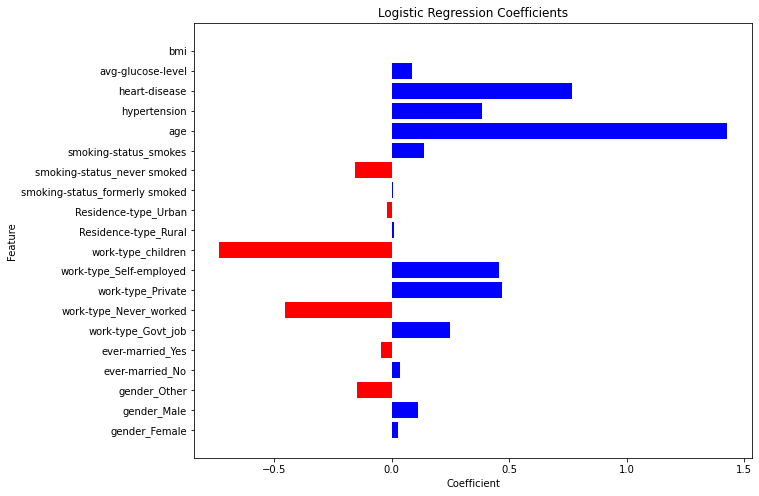

In [59]:
plt.figure(figsize=(10, 8))
colors = ['red' if c < 0 else 'blue' for c in lr_class_weight_hp_tuned.coef_[0]]
plt.barh(range(lr_class_weight_hp_tuned.coef_.shape[1]), lr_class_weight_hp_tuned.coef_[0],color=colors)
plt.yticks(range(lr_class_weight_hp_tuned.coef_.shape[1]),X_train.columns)
plt.ylabel('Feature')
plt.xlabel('Coefficient')
plt.title('Logistic Regression Coefficients')
plt.show()

From the abvove plot we can say that 'stroke' have strongest positive dependency on 'stroke' followed by 'heart-disease' and 'hypertension' and negative dependecy of person being 'children'.

### b) Decision Tree Classifier with Class Reweighting

Let's build our second model using Decision Tree. First we will build Decision Tree with default value of hyper-parameters without Class Reweighting.  

In [60]:
dr_model = DecisionTreeClassifier(random_state=rs)

In [61]:
dr_model.fit(X_train, y_train.values.ravel())

DecisionTreeClassifier(random_state=12)

In [62]:
y_preds_dr = dr_model.predict(X_test)

From the below values we can say that 'dr_model' didn't perform well.

In [63]:
evaluate_metrics(y_test, y_preds_dr)

Accuracy is: 0.96
Precision is: 0.05
Recall is: 0.05
Fscore is: 0.05
AUC is: 0.51


Our next step is to built a Decision Tree with class_weight.

In [64]:
dt_model_class_weight = DecisionTreeClassifier(class_weight=class_weight,random_state=rs)

In [65]:
dt_model_class_weight.fit(X_train, y_train)
y_preds_dt_class_weight = dt_model_class_weight.predict(X_test)

We can see that Class Reweighting didn't help with AUC and Recall of the model. The main reason for this can be said to be overfitting of the model.

In [66]:
evaluate_metrics(y_test, y_preds_dt_class_weight)

Accuracy is: 0.96
Precision is: 0.04
Recall is: 0.05
Fscore is: 0.05
AUC is: 0.51


Let's tune the hyper-parameters of decision tree with class weight in hope for getting better result.(Below cells can be uncommented to look in to the results of Grid-search)

In [67]:
# param_grid_dt = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [2, 5, 8],
#     'class_weight': [{0:0.05, 1:0.95},{0:0.01, 1:0.99}],
#     'min_samples_split': [2, 4, 6],
#     'max_features' : ["sqrt", "log2"]
# }

In [68]:
# cv = StratifiedKFold(n_splits=5)
# dt_grid_search = GridSearchCV(estimator=dr_model,param_grid=param_grid_dt,
#                               scoring='roc_auc',cv=cv,n_jobs=8)
# dt_grid_search.fit(X_train, y_train.values.ravel())

In [69]:
# dt_grid_search_best=dt_grid_search.best_estimator_
# print(dt_grid_search_best.get_params())

In [70]:
# y_preds_dt_grid_search_best=dt_grid_search_best.predict(X_test)

In [71]:
# evaluate_metrics(y_test, y_preds_dt_grid_search_best)

A Decision Tree model is bulit with class_weight using tuned hyper-parameters and trained in the below cells.

In [72]:
dt_class_weight_hp_tuned=DecisionTreeClassifier(ccp_alpha=0.0, 
        class_weight={0: 0.05, 1: 0.95}, criterion = 'gini', 
        max_depth = 5, max_features = 'sqrt', 
        max_leaf_nodes = None, min_impurity_decrease = 0.0, 
        min_samples_leaf = 1, min_samples_split = 2, 
        min_weight_fraction_leaf = 0.0, random_state = rs, splitter = 'best')

In [73]:
dt_class_weight_hp_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.05, 1: 0.95}, max_depth=5,
                       max_features='sqrt', random_state=12)

In [74]:
y_preds_dt_class_weight_hp_tuned=dt_class_weight_hp_tuned.predict(X_test)

We can see that the performance of the Decision Tree have been imporved from the below data.

In [75]:
evaluate_metrics(y_test, y_preds_dt_class_weight_hp_tuned)

Accuracy is: 0.82
Precision is: 0.06
Recall is: 0.54
Fscore is: 0.21
AUC is: 0.68


Let's look into the Tree made by  latest Decision Tree.

In [76]:
tree_exp = export_text(dt_class_weight_hp_tuned, feature_names=list(X_train.columns))

From the Tree below we can see that High 'age' and having 'hypertension' and 'heart-disease' have dominating effect on 'stroke'.

In [77]:
print(tree_exp)

|--- ever-married_Yes <= 0.50
|   |--- heart-disease <= 0.50
|   |   |--- work-type_Private <= 0.50
|   |   |   |--- work-type_Self-employed <= 0.50
|   |   |   |   |--- Residence-type_Rural <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Residence-type_Rural >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- work-type_Self-employed >  0.50
|   |   |   |   |--- hypertension <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- hypertension >  0.50
|   |   |   |   |   |--- class: 1
|   |   |--- work-type_Private >  0.50
|   |   |   |--- age <= 1.05
|   |   |   |   |--- smoking-status_formerly smoked <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- smoking-status_formerly smoked >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- age >  1.05
|   |   |   |   |--- smoking-status_smokes <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- smoking-status_smokes >  0.50
|   |   |   |   |   |--- class: 1
|   |--- heart-disease >  0

### c) Bagging

In this section we will build a Bagging Classifier. Let's first built a bagging classifier using hyper-parameter tuned Decison Tree from the last section.

In [78]:
bag_model = BaggingClassifier(estimator= dt_class_weight_hp_tuned ,n_estimators=20,
                              random_state=rs,bootstrap =  True)

In [79]:
bag_model.fit(X_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={0: 0.05,
                                                                 1: 0.95},
                                                   max_depth=5,
                                                   max_features='sqrt',
                                                   random_state=12),
                  n_estimators=20, random_state=12)

In [80]:
y_preds_bag = bag_model.predict(X_test)

From the below scores, we can say that Bagging classifier is overfitting to data.

In [81]:
evaluate_metrics(y_test, y_preds_bag)

Accuracy is: 0.92
Precision is: 0.07
Recall is: 0.20
Fscore is: 0.14
AUC is: 0.57


Let's tune hyper-parameter of Bagging Classifier.

In [82]:
# param_grid_bag = {'n_estimators': [5,10,20,30,50],
#     'estimator__criterion': ['gini', 'entropy'],
#     'estimator__max_depth': [2, 5, 8],
#     'estimator__class_weight': [{0:0.05, 1:0.95},{0:0.01, 1:0.99}],
#     'estimator__min_samples_split': [2, 4, 6], 
#     'estimator__max_features' : ["sqrt", "log2",None],
#                  }

In [83]:
# cv = StratifiedKFold(n_splits=5)
# bag_grid_search = GridSearchCV(estimator=bag_model, param_grid=param_grid_bag,
#                                scoring='roc_auc', cv=cv,n_jobs=8)

In [84]:
# bag_grid_search.fit(X_train, y_train)

In [85]:
# bag_grid_search_best=bag_grid_search.best_estimator_
# print(bag_grid_search_best.get_params())

In [86]:
# y_preds_bag_grid_search_best=bag_grid_search_best.predict(X_test)

In [87]:
# evaluate_metrics(y_test, y_preds_bag_grid_search_best)

In [88]:
bag_class_weight_hp_tuned=BaggingClassifier(DecisionTreeClassifier(ccp_alpha=0.0, 
        class_weight={0: 0.05, 1: 0.95}, criterion = 'entropy', 
        max_depth = 5, max_features = None, 
        max_leaf_nodes = None, min_impurity_decrease = 0.0, 
        min_samples_leaf = 1, min_samples_split = 2, 
        min_weight_fraction_leaf = 0.0, random_state = rs, splitter = 'best'),n_estimators=30,oob_score= False,
        random_state=12,warm_start=False,max_features =1.0, max_samples = 1.0,
        n_jobs=8,bootstrap = True,bootstrap_features= False)

In [89]:
bag_class_weight_hp_tuned.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={0: 0.05,
                                                                 1: 0.95},
                                                   criterion='entropy',
                                                   max_depth=5,
                                                   random_state=12),
                  n_estimators=30, n_jobs=8, random_state=12)

In [90]:
y_preds_bag_class_weight_hp_tuned=bag_class_weight_hp_tuned.predict(X_test)

We can see that BaggingClassifier performed poorly comared to Decision Tree. The reason in the highly co-related trees in the model.

In [91]:
evaluate_metrics(y_test, y_preds_bag_class_weight_hp_tuned)

Accuracy is: 0.88
Precision is: 0.07
Recall is: 0.38
Fscore is: 0.20
AUC is: 0.63


Let's visualize the co-relation of the models.

In [92]:
def get_correlation(X_test, y_test,models):
    #This function calculates the average correlation between predictors  
    n_estimators=len(models.estimators_)
    prediction=np.zeros((y_test.shape[0],n_estimators))
    predictions=pd.DataFrame({'estimator '+str(n+1):[] for n in range(n_estimators)})
    
    for key,model in zip(predictions.keys(),models.estimators_):
        predictions[key]=model.predict(X_test.to_numpy())
    
    corr=predictions.corr()
    print("Average correlation between predictors: ", corr.mean().mean()-1/n_estimators)
    return corr

As we can see that co-relation between  trees are very high which can cause overfitting to data.

In [93]:
get_correlation(X_test, y_test,bag_class_weight_hp_tuned).style.background_gradient(cmap='coolwarm')

Average correlation between predictors:  0.6884925242014348


,estimator 1,estimator 2,estimator 3,estimator 4,estimator 5,estimator 6,estimator 7,estimator 8,estimator 9,estimator 10,estimator 11,estimator 12,estimator 13,estimator 14,estimator 15,estimator 16,estimator 17,estimator 18,estimator 19,estimator 20,estimator 21,estimator 22,estimator 23,estimator 24,estimator 25,estimator 26,estimator 27,estimator 28,estimator 29,estimator 30
estimator 1,1.000000,0.775049,0.634038,0.703455,0.775020,0.783058,0.750484,0.771855,0.710915,0.702853,0.762601,0.791055,0.737843,0.761883,0.827109,0.667314,0.637694,0.817590,0.803936,0.801408,0.832655,0.777187,0.836266,0.814630,0.704327,0.746254,0.624567,0.747727,0.518873,0.617395
estimator 2,0.775049,1.000000,0.649209,0.831671,0.729819,0.818294,0.699163,0.700093,0.678399,0.654163,0.748413,0.675182,0.733695,0.730739,0.748345,0.679270,0.675304,0.776070,0.745753,0.715204,0.697485,0.889141,0.789125,0.757593,0.676216,0.727023,0.664962,0.854878,0.560455,0.643972
estimator 3,0.634038,0.649209,1.000000,0.640112,0.624351,0.685644,0.644349,0.715179,0.606440,0.675341,0.619656,0.671081,0.627515,0.793788,0.729773,0.556991,0.567966,0.735443,0.728462,0.731330,0.679164,0.640260,0.711540,0.731272,0.578165,0.657421,0.659202,0.644098,0.423045,0.573945
estimator 4,0.703455,0.831671,0.640112,1.000000,0.632428,0.849594,0.678887,0.775612,0.707999,0.637750,0.707394,0.692120,0.717292,0.708284,0.733438,0.703663,0.673364,0.742511,0.739288,0.717913,0.716575,0.868082,0.793180,0.750296,0.698581,0.781295,0.697264,0.832935,0.566059,0.647981
estimator 5,0.775020,0.729819,0.624351,0.632428,1.000000,0.693521,0.695992,0.713706,0.617462,0.631713,0.665438,0.712423,0.658013,0.737153,0.780757,0.588423,0.559180,0.788726,0.779186,0.752860,0.714650,0.717102,0.738355,0.768754,0.571751,0.638099,0.553810,0.666368,0.458991,0.568890
estimator 6,0.783058,0.818294,0.685644,0.849594,0.693521,1.000000,0.728623,0.787505,0.745660,0.697334,0.747911,0.752520,0.758470,0.763659,0.802921,0.721356,0.715605,0.816596,0.791811,0.751898,0.795856,0.847871,0.884944,0.776352,0.771040,0.817272,0.700783,0.827734,0.548521,0.669866
estimator 7,0.750484,0.699163,0.644349,0.678887,0.695992,0.728623,1.000000,0.752381,0.669988,0.664546,0.648481,0.739469,0.675406,0.765972,0.787558,0.560947,0.579253,0.816127,0.774563,0.755289,0.727649,0.706195,0.730100,0.763032,0.643026,0.674968,0.551904,0.657096,0.466789,0.544394
estimator 8,0.771855,0.700093,0.715179,0.775612,0.713706,0.787505,0.752381,1.000000,0.704076,0.738776,0.722480,0.842901,0.753139,0.805062,0.855552,0.664806,0.644283,0.835234,0.874222,0.850676,0.840096,0.732158,0.851017,0.881461,0.694872,0.771794,0.698500,0.728692,0.487225,0.659327
estimator 9,0.710915,0.678399,0.606440,0.707999,0.617462,0.745660,0.669988,0.704076,1.000000,0.610461,0.735545,0.662961,0.674857,0.695414,0.742420,0.579166,0.759680,0.746422,0.722034,0.684666,0.701064,0.694716,0.758580,0.713610,0.735467,0.698175,0.566935,0.672660,0.531356,0.569306
estimator 10,0.702853,0.654163,0.675341,0.637750,0.631713,0.697334,0.664546,0.738776,0.610461,1.000000,0.726522,0.800891,0.813832,0.784030,0.761722,0.630888,0.583860,0.736444,0.745444,0.731549,0.764281,0.671875,0.738432,0.734722,0.665725,0.668088,0.648911,0.654821,0.507212,0.661793


### d) Random Forest Classifier with Class Reweighting

Let's built our next ensemble model called Random Forest Classifier. 

First we will build a model with default value of RandomForestClassifier.

In [94]:
rf_model = RandomForestClassifier( max_features='sqrt',n_estimators=10, random_state=rs)

In [95]:
rf_model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, random_state=12)

In [96]:
y_preds_rf = rf_model.predict(X_test)

This RandomForestModel didn't perform well as we can see different scores below.

In [97]:
evaluate_metrics(y_test, y_preds_rf)

Accuracy is: 0.98
Precision is: 0.00
Recall is: 0.00
Fscore is: 0.00
AUC is: 0.50


Now we will built a model with class_weight parameter and will tune the hyper-parameter.

In [98]:
# params_grid_rf = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [3, 5, 8],
#     'n_estimators': [5,10,20],
#     'class_weight': [{0:1, 1:50},{0:1,1:25},"balanced_subsample"],
#     'max_features': ["log2", "sqrt",None],
#     }

In [99]:
# cv = StratifiedKFold(n_splits=5)

In [100]:
# rf_grid_search = GridSearchCV(estimator = rf_model, 
#                            param_grid = params_grid_rf, 
#                            scoring='roc_auc',
#                            cv = cv,n_jobs=8)

In [101]:
# rf_grid_search.fit(X_train,y_train)

In [102]:
# rf_grid_search_best=rf_grid_search.best_estimator_
# print(rf_grid_search_best.get_params())

In [103]:
# y_preds_rf_grid_search_best=rf_grid_search_best.predict(X_test)

In [104]:
# evaluate_metrics(y_test, y_preds_rf_grid_search_best)

Below a RandomForestClassifier model is bulit with tuned hyper-parameter.

In [105]:
rf_class_weight_hp_tuned=RandomForestClassifier(bootstrap = True,
                                                 class_weight ={0: 1, 1: 50}, criterion = 'gini', 
                                                  max_depth =  3, max_features = None, 
                                                 n_estimators = 10, n_jobs = 8, 
                                                 random_state = rs)

In [106]:
rf_class_weight_hp_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 50}, max_depth=3,
                       max_features=None, n_estimators=10, n_jobs=8,
                       random_state=12)

In [107]:
y_preds_rf_class_weight_hp_tuned=rf_class_weight_hp_tuned.predict(X_test)

After training, we can see different scores of the model and this model outperformed other models in terms of AUC and Recall.

In [108]:
evaluate_metrics(y_test, y_preds_rf_class_weight_hp_tuned)

Accuracy is: 0.71
Precision is: 0.05
Recall is: 0.72
Fscore is: 0.20
AUC is: 0.72


####  Random Forest model explanation with Permutation Feature Importance

In [109]:
def visualize_feature_importance(importance_array):
    # Sort the array based on mean value
    sorted_idx = importance_array.importances_mean.argsort()
    # Visualize the feature importances using boxplot
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(10)
    fig.tight_layout()
    ax.boxplot(importance_array.importances[sorted_idx].T,
               vert=False, labels=X_train.columns[sorted_idx])
    ax.set_title("Permutation Importances (train set)")
    plt.show()

In [110]:
feature_importances_rf = permutation_importance(estimator = rf_class_weight_hp_tuned, X = X_train, y = y_train, n_repeats=5,
                                random_state=rs, n_jobs=8)

The below chart give us the importance of features, according to current model, for 'stroke' 

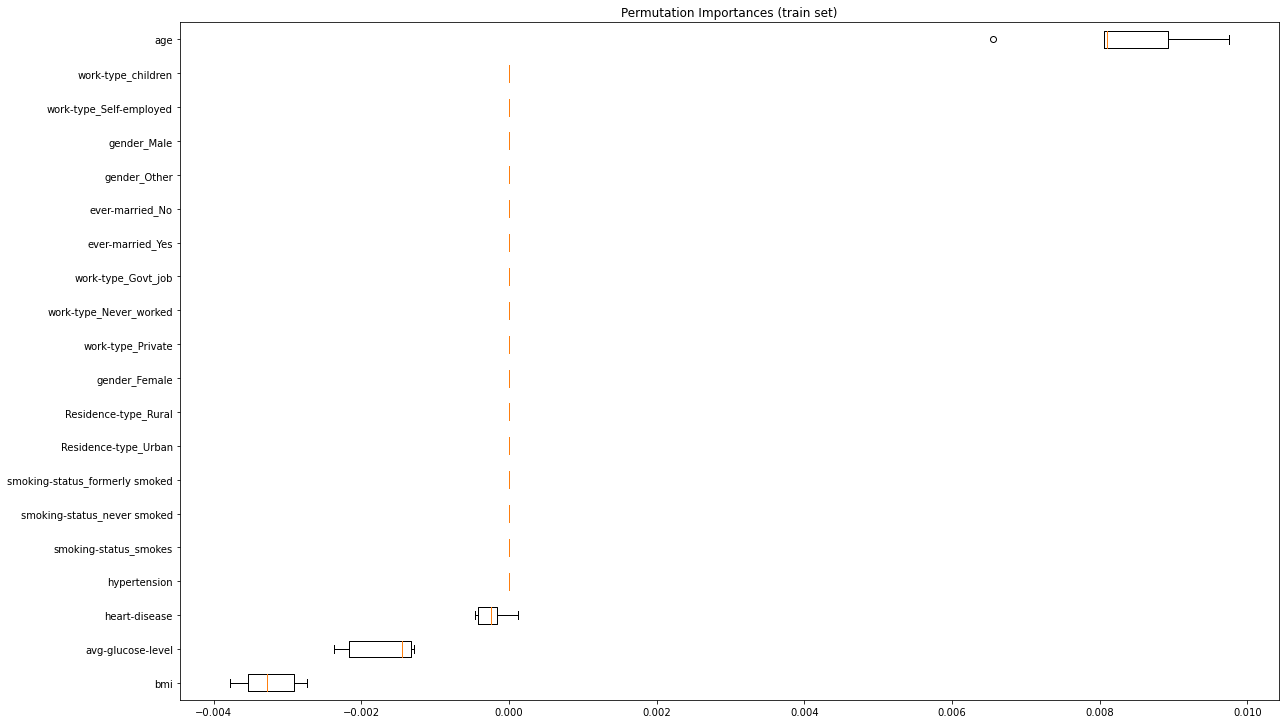

In [111]:
visualize_feature_importance(feature_importances_rf)

#### Random Forest model explanation with LIME

In this part we will try to understand why our Random Forest Model thinks that a person will have stroke or not.

In [112]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_test.values,
    mode='classification',
    class_names = ['no_stroke', 'stroke'],
    feature_names=list(X_train.columns),
    random_state=rs,
    verbose=True)

Let's take a instance of data.

In [113]:
instance_index = 55
selected_instance_55 = X_test.iloc[[instance_index]]
lime_test_instance_55 = selected_instance_55.values.reshape(-1)
selected_instance_55

,gender_Female,gender_Male,gender_Other,ever-married_No,ever-married_Yes,work-type_Govt_job,work-type_Never_worked,work-type_Private,work-type_Self-employed,work-type_children,Residence-type_Rural,Residence-type_Urban,smoking-status_formerly smoked,smoking-status_never smoked,smoking-status_smokes,age,hypertension,heart-disease,avg-glucose-level,bmi
55,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1.765781,0,1,0.931193,-0.593977


Let's see what class in assigned to this instance by  RandomForest.

In [114]:
rf_class_weight_hp_tuned.predict(selected_instance_55)

array([1], dtype=int64)

Now we we try to understand why our model thing that this class belongs to 'stroke' class 1.

Intercept 0.2046452911615201
Prediction_local [0.83092882]
Right: 0.8666127526251433


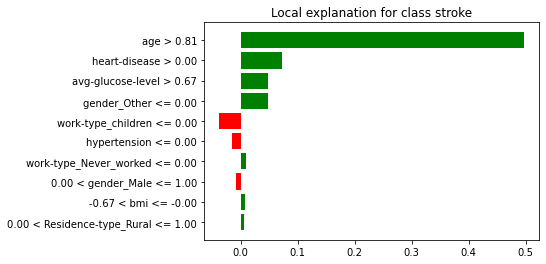

In [115]:
exp_rf_55 = explainer.explain_instance(
                                 lime_test_instance_55, 
                                 rf_class_weight_hp_tuned.predict_proba,
                                 num_features=10)
exp_rf_55.as_pyplot_figure();

The reason of that is clearly high 'age' and presence of 'heart_disease' and high 'avg_glucose_level'.

### e) Boosting Classifiers with Class Reweighting

#### i) AdaBoostClassifier

We will first try Adaboost(a popular boosting algorithm) with default hyper-parameters value.

In [116]:
ab_model = AdaBoostClassifier(n_estimators=30,random_state=rs)

In [117]:
ab_model.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=30, random_state=12)

In [118]:
y_preds_ab = ab_model.predict(X_test)

Default Adaboost didn't perform well on the data.

In [119]:
evaluate_metrics(y_test, y_preds_ab)

Accuracy is: 0.98
Precision is: 0.00
Recall is: 0.00
Fscore is: 0.00
AUC is: 0.50


In Adaboost there is no class_weight like parameter to give certain class more weightage. So, we will use GridSearchCV's sample_weight parameter to give weightage to positive class. In the below cell weightage is defined.

In [120]:
sample_weights_ab = compute_sample_weight('balanced', y_train)

Let's tune the hyper-parameter of the AdaboostClassifier.(Below cells can be uncommented to do the hyper-parameter tuning.)

In [121]:
# param_grid_ab = {
#     'learning_rate': [0.001,0.01, 0.1, 1],
#     'n_estimators': [30,50, 100,200,300],
#     'algorithm': ['SAMME.R','SAMME']
# }

In [122]:
# cv = StratifiedKFold(n_splits=5)

In [123]:
# ab_grid_search = GridSearchCV(estimator = ab_model, 
#                            param_grid = param_grid_ab, 
#                            scoring='roc_auc',
#                            cv = cv,n_jobs=8)

In [124]:
# ab_grid_search.fit(X_train,y_train,sample_weight=sample_weights_ab)

In [125]:
# ab_grid_search_best=ab_grid_search.best_estimator_
# print(ab_grid_search_best.get_params())

In [126]:
# y_preds_ab_grid_search_best=ab_grid_search_best.predict(X_test)

In [127]:
# evaluate_metrics(y_test, y_preds_ab_grid_search_best)

Now we will build a model with tuned hyper-parameters.

In [128]:
ab_class_weight_hp_tuned=AdaBoostClassifier(algorithm ='SAMME.R',
                                            estimator = None,  learning_rate = 0.1, 
                                            n_estimators = 200, random_state = rs)

In [129]:
ab_class_weight_hp_tuned.fit(X_train, y_train,sample_weight=sample_weights_ab)

AdaBoostClassifier(learning_rate=0.1, n_estimators=200, random_state=12)

In [130]:
y_preds_ab_class_weight_hp_tuned=ab_class_weight_hp_tuned.predict(X_test)

The score of this is slight improvement over the RandomForestModel.

In [131]:
evaluate_metrics(y_test, y_preds_ab_class_weight_hp_tuned)

Accuracy is: 0.73
Precision is: 0.06
Recall is: 0.75
Fscore is: 0.22
AUC is: 0.74


#### AdaBoostClassifier explanation with Permutation Feature Importance

In [132]:
feature_importances_ab = permutation_importance(estimator = ab_class_weight_hp_tuned, X = X_train, y = y_train, n_repeats=5,
                                random_state=rs, n_jobs=8)


The below chart give us the importance of features, according to current model, for 'stroke' 

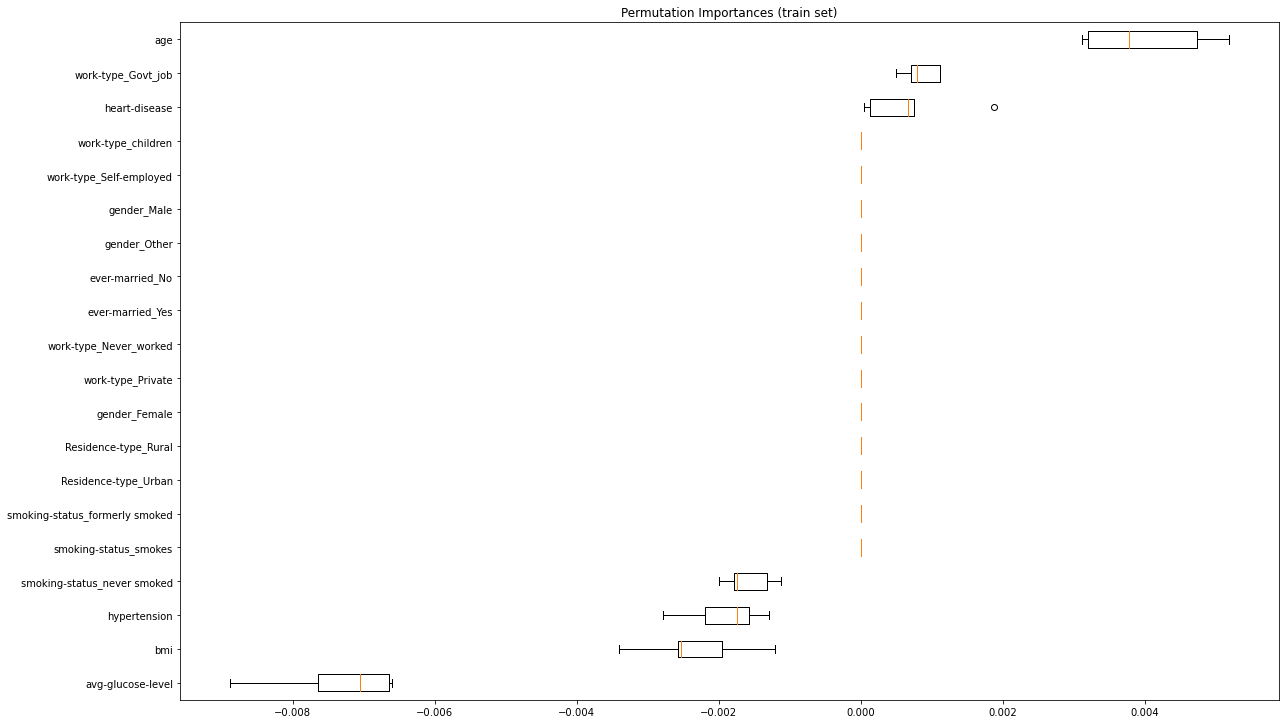

In [133]:
visualize_feature_importance(feature_importances_ab)

Let's take a instance of data with index 55 in test set. 

Let's see what class in assigned to this instance by AdaBoostClassifier..

In [134]:
ab_class_weight_hp_tuned.predict(selected_instance_55)

array([1], dtype=int64)

Now we we try to understand why our model thing that this class belongs to 'stroke' class 1.

Intercept 0.4868151857259181
Prediction_local [0.52410887]
Right: 0.5205735224456782


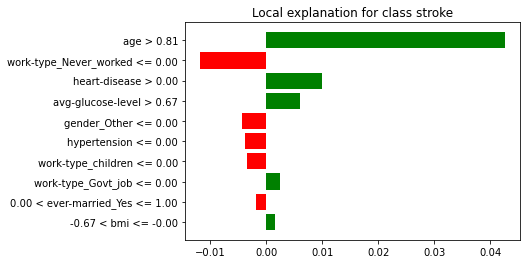

In [135]:
exp_rf_55 = explainer.explain_instance(
                                 lime_test_instance_55, 
                                 ab_class_weight_hp_tuned.predict_proba,
                                 num_features=10)
exp_rf_55.as_pyplot_figure();

The reason of that is clearly again high 'age' and presence of 'heart_disease' and high 'avg_glucose_level'as also predicted by RandomForest

#### ii) XGBClassifier

In this section we will use another Boosting algorithm called XGBoost. We will directly directly dive into the hyper-parameter tuning of the XGBClassifier with Class Reweighting. In this model scale_pos_weight hyper-parameter will help us in Class Reweighting.(Uncommented the belows cells to get the tuned hyper-parameter)

In [136]:
# param_grid_xgb = {
#     'learning_rate': [0.1, 0.2, 0.5],
#     'max_depth': [1,3, 6],
#     'n_estimators': [50,100,200],
#     'scale_pos_weight': [50,75,90],
#     'reg_alpha':[0, 1, 10]
# }


In [137]:
# cv = StratifiedKFold(n_splits=5)

In [138]:
# xgb_grid_search = GridSearchCV(estimator = xgb_model, 
#                            param_grid = param_grid_xgb, 
#                            scoring='roc_auc',
#                            cv = cv,n_jobs=8)

In [139]:
# xgb_grid_search.fit(X_train,y_train)

In [140]:
# xgb_grid_search_best=xgb_grid_search.best_estimator_
# print(xgb_grid_search_best.get_params())

In [141]:
# y_preds_xgb_grid_search_best=xgb_grid_search_best.predict(X_test)

In [142]:
# evaluate_metrics(y_test, y_preds_xgb_grid_search_best)

Let's build a XGBClassifier Model with tuned hyper-parameters.

In [143]:
xgb_class_weight_hp_tuned = XGBClassifier(objective = 'binary:logistic', 
                                           learning_rate = 0.1, max_depth = 1,
                                           n_estimators = 200, n_jobs = 8,  random_state = rs, 
                                           reg_alpha = 10, scale_pos_weight = 50)

In [144]:
xgb_class_weight_hp_tuned.fit(X_train, y_train,sample_weight=sample_weights_ab)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=8, num_parallel_tree=None,
              predictor=None, random_state=12, ...)

In [145]:
y_preds_xgb_class_weight_hp_tuned=ab_class_weight_hp_tuned.predict(X_test)

The scores are almost equal of that of AdaboostClassifier.

In [146]:
evaluate_metrics(y_test, y_preds_xgb_class_weight_hp_tuned)

Accuracy is: 0.73
Precision is: 0.06
Recall is: 0.75
Fscore is: 0.22
AUC is: 0.74


# 5. Choice of Final Model

For our task AdaBoostClassifier (ab_class_weight_hp_tuned) is best model as for this model our Recall and AUC is highest. Higher Recall will ensure that 'Stroke' class 1 will be predicted correctly most of time and higher AUC will ensure that precision will also be maintained. For interpretibility Logistic Regression will be the best choice as it is simple and easy to understand and its Recall and AUC value is also good.

# 6. Insights and key findings

i)    Our target variable 'stroke' have class imabalance. So we decided to go with Class Reweighting method to fit our model to the data.

ii)   Attributes 'bmi' and 'avg_glucose_level' had skewed distribution. So, we converted the distribution to get distribution close to normal.

iii)  We find out using box-plots that 'stroke' might depend on 'age' and 'avg_glucose_level'. Statistically also we find out 'stroke' does depend        'avg_glucose_level'

iv)   We find out using bar plots that 'heart_disease' and 'hypertension' have effect on 'stroke'. We statistically find out also that 'stroke' depend on 'smoking_status'.

v)    We fit simple models like Logistic regression and Desicion Tree to the data with class_weight and by plotting co-efficient and tree we get a explanation of this models and find out that 'age','hypertension' and 'avg_glucose_level' have highest effect on 'stroke'.

vi)   We fitted complex models like RandomForest,Adaboost and XGBoost  to the data and get better Recall and AUC value.

vii) Model explanation of complex models give us expected results.

# 7. Next Steps

For next step we can reduce the dimension and co-linearity of the dataset using Principal Component Analysis.

In [147]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

PCA()

In [148]:
X_train_hat = pca.transform(X_train)
print(X_train_hat.shape)

(24086, 20)


From the below graph we can see that arond 12 PCA component can explain all the variance of the dataset.

Text(0.5, 1.0, 'Component-wise variance and cumulative explained variance')

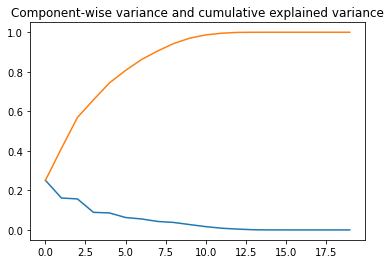

In [149]:
plt.plot(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise variance and cumulative explained variance")

In [150]:
X_train_hat_PCA = pd.DataFrame(columns=[f'Projection  on Component {i+1}' for i in range(len(X_train.columns))], data=X_train_hat)
X_train_hat_PCA.head()

,Projection on Component 1,Projection on Component 2,Projection on Component 3,Projection on Component 4,Projection on Component 5,Projection on Component 6,Projection on Component 7,Projection on Component 8,Projection on Component 9,Projection on Component 10,Projection on Component 11,Projection on Component 12,Projection on Component 13,Projection on Component 14,Projection on Component 15,Projection on Component 16,Projection on Component 17,Projection on Component 18,Projection on Component 19,Projection on Component 20
0,1.513380,0.827509,-0.734243,0.671974,-0.326984,-0.919682,0.138435,-0.138994,0.745018,-0.023561,-0.001464,-0.000701,-0.079133,-0.009685,-0.000590,-1.837310e-14,-1.034748e-14,1.330316e-14,7.452465e-15,3.335093e-15
1,1.962985,0.603446,-1.015733,0.580663,-0.647087,0.154672,-0.124947,0.348982,0.121205,-0.044302,0.036309,0.033686,-0.132347,-0.013737,-0.000249,-1.762604e-14,-1.047138e-14,1.303526e-14,-9.507907e-16,3.394525e-15
2,-0.091623,-1.564755,-0.557198,0.491845,-0.801925,0.731839,0.767763,0.933890,1.064514,-0.224101,-0.294531,-0.149493,-0.061234,-0.009278,0.000475,-1.716453e-14,1.728772e-14,1.304398e-14,-5.250597e-17,3.627281e-15
3,-1.658878,0.907122,0.943316,-0.590801,0.613423,1.009925,0.375291,-0.255129,-0.140987,0.789699,-0.253723,-0.083934,0.009425,-0.003875,0.000195,2.740943e-14,1.821676e-14,-4.276419e-15,6.598729e-16,-3.334364e-15
4,1.477564,1.696559,1.421015,-0.541460,0.882574,0.846093,0.645562,0.254061,0.093813,-0.045046,0.003744,0.074422,1.002417,-0.049363,-0.004833,2.756187e-14,4.744213e-14,1.337360e-14,1.623489e-16,-2.782898e-15


In [151]:
X_test_hat = pca.transform(X_test)
print(X_test_hat.shape)

(6022, 20)


In [152]:
X_test_hat_PCA = pd.DataFrame(columns=[f'Projection  on Component {i+1}' for i in range(len(X_train.columns))], data=X_test_hat)
X_test_hat_PCA.head()

,Projection on Component 1,Projection on Component 2,Projection on Component 3,Projection on Component 4,Projection on Component 5,Projection on Component 6,Projection on Component 7,Projection on Component 8,Projection on Component 9,Projection on Component 10,Projection on Component 11,Projection on Component 12,Projection on Component 13,Projection on Component 14,Projection on Component 15,Projection on Component 16,Projection on Component 17,Projection on Component 18,Projection on Component 19,Projection on Component 20
0,0.304249,1.438112,-0.143436,0.660156,-0.463629,-0.946559,-0.138142,-1.000122,-0.042399,-0.260897,0.010134,0.039189,-0.003631,-0.001560,-0.000395,-1.799226e-14,-9.891776e-15,-3.909191e-15,8.622375e-15,3.316251e-15
1,-0.652769,-0.674121,0.931381,-0.769352,-0.243127,-0.839663,-0.283950,0.539307,-0.313731,0.071404,-0.173618,-0.078451,0.065153,0.006809,-0.000862,-1.688683e-14,-1.006159e-14,-5.019851e-15,-7.979539e-15,-3.446438e-15
2,-0.508370,-1.224947,-0.952158,0.774737,0.471552,1.063454,0.368676,-0.119564,-0.001132,-0.543537,-0.204119,-0.123587,-0.055434,-0.005778,0.000497,2.719491e-14,1.679711e-14,-3.829035e-15,1.073576e-15,3.478464e-15
3,-1.733084,-0.576129,-0.744612,0.597493,-0.595509,-0.814711,-0.327749,0.653294,-0.196926,0.144175,-0.253515,-0.140886,0.081243,0.007782,-0.000562,-1.710600e-14,-1.009244e-14,-4.967248e-15,-8.131963e-15,3.572655e-15
4,-0.764289,-0.576871,2.005362,-0.528769,1.053006,-0.042396,0.811473,0.388732,-0.328189,-0.581932,-0.207250,-0.105047,-0.008056,-0.001868,-0.000926,2.743991e-14,1.650817e-14,-4.652778e-15,-6.992907e-15,-3.273108e-15


We will select 12 PCA components to create attribute of our train and test set.

In [153]:
N = 12
X_train_hat_PCA = X_train_hat_PCA.iloc[:, :N]

In [154]:
X_test_hat_PCA = X_test_hat_PCA.iloc[:, :N]

#### RandomForest using PCA transformed data with class_weight

We will create a RandomForestClassifier with PCA transformed data using class_weight

In the below cell RandomForestClassifier is tuned.

In [155]:
# params_grid_rf_class_weight_pca = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [1, 3, 5, 8],
#     'n_estimators': [5,10,20,40],
#     'class_weight': [{0:1, 1:50},{0:1,1:25},"balanced_subsample"],
#     'max_features': ["log2", "sqrt",None],
#     }

In [156]:
# cv = StratifiedKFold(n_splits=5)

In [157]:
# rf_pca_class_weight_grid_search = GridSearchCV(estimator = rf_model, 
#                            param_grid = params_grid_rf_class_weight_pca,
#                            scoring='roc_auc',
#                            cv = cv,n_jobs=8)

In [158]:
# rf_pca_class_weight_grid_search.fit(X_train_hat_PCA,y_train)

In [159]:
# rf_pca_class_weight_grid_search_best=rf_pca_class_weight_grid_search.best_estimator_
# print(rf_pca_class_weight_grid_search_best.get_params())

In [160]:
# y_preds_rf_pca_class_weight_grid_search_best=rf_pca_class_weight_grid_search_best.predict(X_test_hat_PCA)

In [161]:
# evaluate_metrics(y_test, y_preds_rf_pca_class_weight_grid_search_best)

We will build a  RandomForestClassifier tuned on PCA transformed train set.

In [162]:
rf_pca_class_weight_hp_tuned=RandomForestClassifier(bootstrap = True,
                                                 class_weight ={0: 1, 1: 25}, criterion = 'entropy', 
                                                  max_depth =  5, max_features = None, 
                                                 n_estimators = 40, n_jobs = 8, 
                                                 random_state = rs)

In [163]:
rf_pca_class_weight_hp_tuned.fit(X_train_hat_PCA,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 25}, criterion='entropy',
                       max_depth=5, max_features=None, n_estimators=40,
                       n_jobs=8, random_state=12)

In [164]:
y_preds_rf_pca_class_weight_hp_tuned=rf_pca_class_weight_hp_tuned.predict(X_test_hat_PCA)

The scores for the model is shown here.

In [165]:
evaluate_metrics(y_test, y_preds_rf_pca_class_weight_hp_tuned)

Accuracy is: 0.85
Precision is: 0.06
Recall is: 0.45
Fscore is: 0.21
AUC is: 0.66


#### RandomForest using PCA transformed data with SMOTE

We will use SMOTE to oversmapling our data ,so the class get balanced in the train set.

In [166]:
smote_sampler = SMOTE(random_state = rs)

In [167]:
X_smo, y_smo = smote_sampler.fit_resample(X_train_hat_PCA, y_train)

<AxesSubplot:>

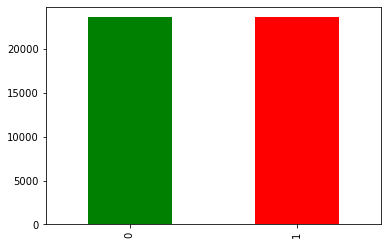

In [168]:
y_smo.value_counts().plot.bar(color=['green', 'red'])

In [169]:
# params_grid_rf_pca_smote = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [1, 3, 5, 8],
#     'n_estimators': [5,10,20,40],
#     'max_features': ["log2", "sqrt",None],
#     }

In [170]:
# cv = StratifiedKFold(n_splits=5)

In [171]:
# rf_pca_smote_grid_search = GridSearchCV(estimator = rf_model, 
#                            param_grid = params_grid_rf_pca_smote, 
#                            scoring='roc_auc',
#                            cv = cv,n_jobs=8)

In [172]:
# rf_pca_smote_grid_search.fit(X_smo,y_smo)

In [173]:
# rf_pca_smote_grid_search_best=rf_pca_smote_grid_search.best_estimator_
# print(rf_pca_smote_grid_search_best.get_params())

In [174]:
# y_preds_rf_pca_smote_grid_search_best=rf_pca_smote_grid_search_best.predict(X_test_hat_PCA)

In [175]:
# evaluate_metrics(y_test, y_preds_rf_pca_smote_grid_search_best)

Hyper-parameter tuned model is shown here along with all the score.

In [176]:
rf_pca_smote_hp_tuned=RandomForestClassifier(bootstrap = True, criterion = 'gini', 
                                                  max_depth =  8, max_features = None, 
                                                 n_estimators = 40, n_jobs = 8, 
                                                 random_state = rs)

In [177]:
rf_pca_smote_hp_tuned.fit(X_smo,y_smo)

RandomForestClassifier(max_depth=8, max_features=None, n_estimators=40,
                       n_jobs=8, random_state=12)

In [178]:
y_preds_rf_pca_smote_hp_tuned=rf_pca_smote_hp_tuned.predict(X_test_hat_PCA)

In [179]:
evaluate_metrics(y_test, y_preds_rf_pca_smote_hp_tuned)

Accuracy is: 0.78
Precision is: 0.06
Recall is: 0.60
Fscore is: 0.21
AUC is: 0.69
